In [ ]:
import torch
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU - Change Runtime Type to GPU!")

!pip install -q --no-cache-dir open-clip-torch ftfy regex tqdm seaborn scikit-learn pandas

GPU: Tesla T4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 194.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

drive_root = "/content/drive/MyDrive/MVTec"
raw_dataset = f"{drive_root}/mvtec_anomaly_detection"
converted_dataset = f"{drive_root}/mvtec_imagefolder"

print("Raw dataset path:", raw_dataset)
print("Converted ImageFolder path:", converted_dataset)


Mounted at /content/drive
Raw dataset path: /content/drive/MyDrive/MVTec/mvtec_anomaly_detection
Converted ImageFolder path: /content/drive/MyDrive/MVTec/mvtec_imagefolder


Running on CUDA


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Using dataset: /content/drive/MyDrive/dataset/mvtec_anomaly_detection
Total test images found: 1725
Normal: 467 | Defective: 1258
Final test set: 967 images (balanced)
Running zero-shot inference on MVTec...


Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


ZERO-SHOT CLIP ACCURACY ON MVTec: 41.68%


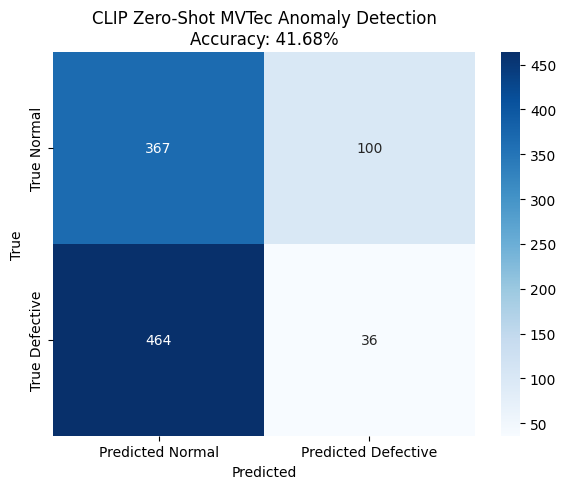


Detailed report:
              precision    recall  f1-score   support

      Normal     0.4416    0.7859    0.5655       467
   Defective     0.2647    0.0720    0.1132       500

    accuracy                         0.4168       967
   macro avg     0.3532    0.4289    0.3393       967
weighted avg     0.3502    0.4168    0.3316       967



In [ ]:
# =====================================================
# CLIP ZERO-SHOT ANOMALY DETECTION ON MVTec (WORKS NOW!)
# =====================================================

import torch
import open_clip
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random
from pathlib import Path

# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device.upper()}")

# Load CLIP (same as before)
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='laion400m_e31')
model.to(device).eval()
tokenizer = open_clip.get_tokenizer('ViT-B-16')

# ------------------------------
# Find MVTec folder (auto-detect common names)
possible_paths = ["/content/drive/MyDrive/dataset/mvtec_anomaly_detection"]
data_root = None
for p in possible_paths:
    if Path(p).exists():
        data_root = Path(p)
        break
if data_root is None:
    raise FileNotFoundError("MVTec folder not found! Check the path.")
print(f"Using dataset: {data_root}")

# ------------------------------
# Collect test images: normal ("good") vs anomalous
samples = []
categories = [p.name for p in data_root.iterdir() if p.is_dir()]

for cat in categories:
    test_dir = data_root / cat / "test"
    if not test_dir.exists():
        continue

    # Normal images
    for img_path in (test_dir / "good").glob("*.png"):
        samples.append((str(img_path), 0, cat))  # 0 = normal

    # Anomalous images (all defect types)
    for defect_type in test_dir.iterdir():
        if defect_type.is_dir() and defect_type.name != "good":
            for img_path in defect_type.glob("*.png"):
                samples.append((str(img_path), 1, cat))  # 1 = defective

print(f"Total test images found: {len(samples)}")
print(f"Normal: {sum(1 for x in samples if x[1]==0)} | Defective: {sum(1 for x in samples if x[1]==1)}")

# ------------------------------
# Optional: take a balanced subset (e.g. 500 normal + 500 defective)
normal = [s for s in samples if s[1] == 0]
defective = [s for s in samples if s[1] == 1]
test_samples = normal[:500] + defective[:500]
random.shuffle(test_samples)
print(f"Final test set: {len(test_samples)} images (balanced)")

# ------------------------------
# Dataset class
class MVTecDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label, _ = self.samples[idx]
        img = Image.open(path).convert("RGB")
        return preprocess(img), torch.tensor(label, dtype=torch.long)

test_dataset = MVTecDataset(test_samples)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# ------------------------------
# Zero-shot text prompts (very effective for industrial!)
prompts = [
    "a photo of a perfect {label} object.",
    "a high-quality industrial image of a {label} product.",
    "a defect-free {label} item on the production line.",
    "a flawless {label} with no scratches, cracks, or contamination.",
    "a normal {label} from quality control.",
]

classes = ["normal", "defective"]
text_inputs = []
for c in classes:
    texts = [p.format(label=c) for p in prompts]
    tokens = tokenizer(texts).to(device)
    with torch.no_grad():
        emb = model.encode_text(tokens)
        emb = emb.mean(dim=0)
        emb /= emb.norm()
    text_inputs.append(emb)

text_features = torch.stack(text_inputs).to(device)

# ------------------------------
# Inference
print("Running zero-shot inference on MVTec...")
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Predicting"):
        imgs = imgs.to(device)
        img_features = model.encode_image(imgs)
        img_features /= img_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * img_features @ text_features.T).softmax(dim=-1)
        preds = similarity.argmax(dim=-1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# ------------------------------
# Results
acc = accuracy_score(all_labels, all_preds)
print(f"\nZERO-SHOT CLIP ACCURACY ON MVTec: {acc*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Defective'],
            yticklabels=['True Normal', 'True Defective'])
plt.title(f'CLIP Zero-Shot MVTec Anomaly Detection\nAccuracy: {acc*100:.2f}%')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nDetailed report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Defective'], digits=4))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Found 15 valid MVTec classes (excluded junk folders):
['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
Total test images collected: 1725
Building object text classifier...
Running inference on MVTec objects...


Predicting:   0%|          | 0/27 [00:00<?, ?it/s]


🎉 ZERO-SHOT ACCURACY: 79.94% (on clean MVTec 15 object/texture classes)


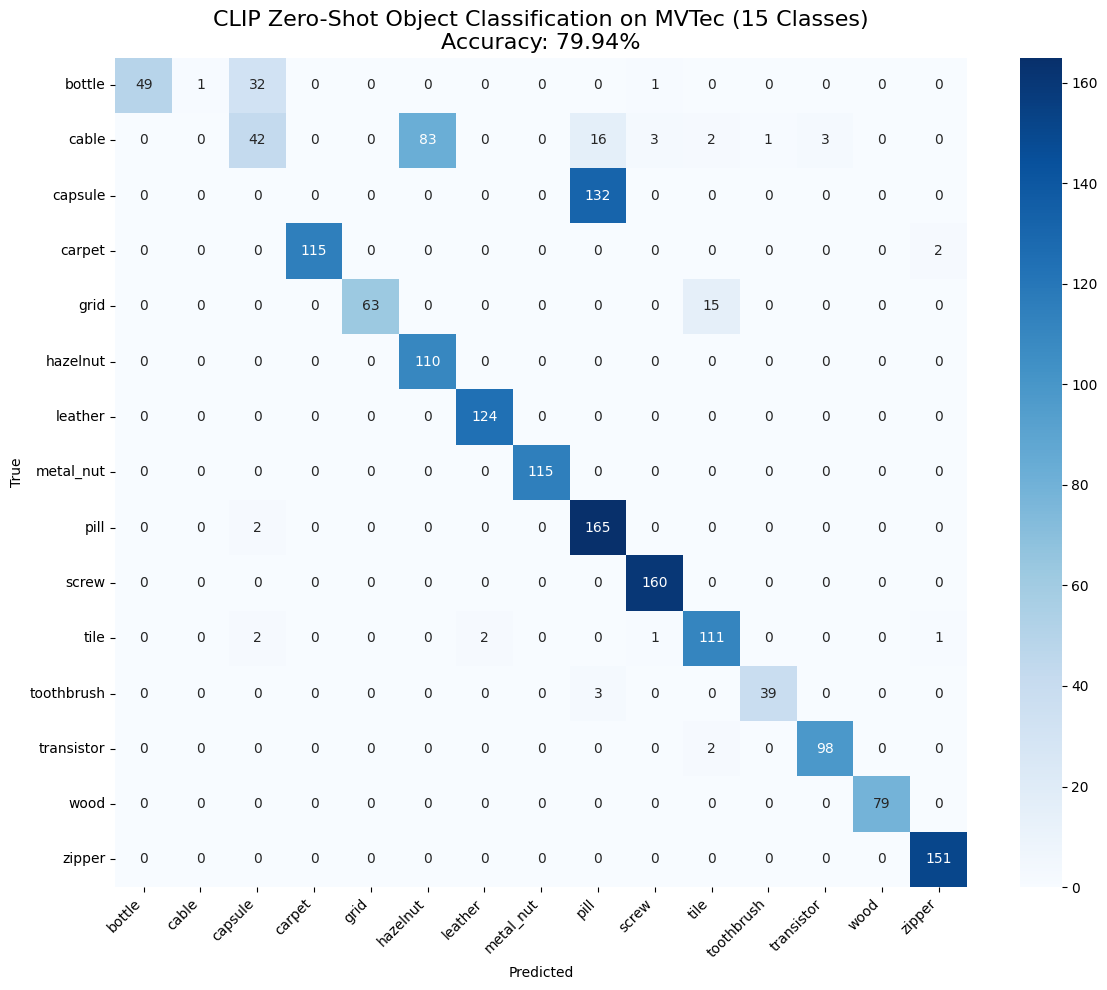


Detailed Report:
              precision    recall  f1-score   support

      bottle     1.0000    0.5904    0.7424        83
       cable     0.0000    0.0000    0.0000       150
     capsule     0.0000    0.0000    0.0000       132
      carpet     1.0000    0.9829    0.9914       117
        grid     1.0000    0.8077    0.8936        78
    hazelnut     0.5699    1.0000    0.7261       110
     leather     0.9841    1.0000    0.9920       124
   metal_nut     1.0000    1.0000    1.0000       115
        pill     0.5222    0.9880    0.6832       167
       screw     0.9697    1.0000    0.9846       160
        tile     0.8538    0.9487    0.8988       117
  toothbrush     0.9750    0.9286    0.9512        42
  transistor     0.9703    0.9800    0.9751       100
        wood     1.0000    1.0000    1.0000        79
      zipper     0.9805    1.0000    0.9902       151

    accuracy                         0.7994      1725
   macro avg     0.7884    0.8151    0.7886      1725
weighted

In [ ]:
# =============================================
# MVTec Object Classification - Zero-Shot CLIP (15 Classes)
# SAFELY EXCLUDE UNWANTED FOLDERS
# =============================================

from pathlib import Path

# Auto-detect MVTec folder
data_root = None
for p in ["/content/drive/MyDrive/dataset/mvtec_anomaly_detection"]:
    if Path(p).exists():
        data_root = Path(p)
        break
if data_root is None:
    raise FileNotFoundError("MVTec dataset folder not found! Please check the path.")

# Folders to completely ignore
exclude_folders = {
    '.git',
    'autoencoder',
    'mvtec-anomaly-detection-full',
    'processing',
    'results',
    'saved_models'
}

# Collect only the real 15 MVTec categories
raw_categories = [d for d in data_root.iterdir() if d.is_dir()]
classes = sorted([d.name for d in raw_categories if d.name not in exclude_folders])

print(f"Found {len(classes)} valid MVTec classes (excluded junk folders):")
print(classes)

# Collect test images from all valid categories
test_samples = []
label_map = {cls: idx for idx, cls in enumerate(classes)}

print("Collecting MVTec test images for object classification...")

for category in raw_categories:
    cat_name = category.name
    if cat_name in exclude_folders:
        print(f"Skipping excluded folder: {cat_name}")
        continue

    test_dir = category / "test"
    if not test_dir.exists():
        continue

    for subfolder in test_dir.iterdir():
        if subfolder.is_dir():
            for img_path in subfolder.glob("*.png"):
                test_samples.append((str(img_path), label_map[cat_name]))

print(f"Total test images collected: {len(test_samples)}")
random.shuffle(test_samples)

# Dataset class (unchanged)
class MVTecTestDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = Image.open(path).convert("RGB")
            return preprocess(img), torch.tensor(label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return preprocess(Image.new('RGB', (224, 224), color='black')), torch.tensor(0)

# Loader
test_dataset = MVTecTestDataset(test_samples)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Tailored prompts for object names
templates = [
    "a photo of a {}.",
    "a close-up photo of a {}.",
    "an industrial photo of a {}.",
    "a high-resolution image of a {}.",
    "a manufactured {}.",
    "a product image of a {}.",
    "a quality control photo of a {}.",
    "a frontal view of a {}.",
    "an image showing a {}."
]

# Build text features
print("Building object text classifier...")
text_features = []
with torch.no_grad():
    for c in classes:
        display_name = c.replace("_", " ")  # e.g., "metal nut"
        texts = [t.format(display_name) for t in templates]
        tokens = tokenizer(texts).to(device)
        emb = model.encode_text(tokens)
        emb /= emb.norm(dim=-1, keepdim=True)
        text_features.append(emb.mean(dim=0))
text_features = torch.stack(text_features)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Zero-shot inference (unchanged)
print("Running inference on MVTec objects...")
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Predicting"):
        imgs = imgs.to(device)
        img_feat = model.encode_image(imgs)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        sim = (100.0 * img_feat @ text_features.T).softmax(dim=-1)
        pred = sim.argmax(dim=-1).cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(labels.numpy())

# Results
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
acc = accuracy_score(all_labels, all_preds)
print(f"\n🎉 ZERO-SHOT ACCURACY: {acc*100:.2f}% (on clean MVTec 15 object/texture classes)")

# Confusion matrix
plt.figure(figsize=(12,10))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title(f'CLIP Zero-Shot Object Classification on MVTec (15 Classes)\nAccuracy: {acc*100:.2f}%', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nDetailed Report:")
print(classification_report(all_labels, all_preds, target_names=classes, digits=4))

In [ ]:
!pip install -q peft accelerate


In [ ]:
# =============================================
# BUILD TRAIN DATASET (from train/good only)
# =============================================
train_samples = []

for category in raw_categories:
    cat_name = category.name
    if cat_name in exclude_folders:
        continue

    train_dir = category / "train" / "good"
    if train_dir.exists():
        for img_path in train_dir.glob("*.png"):
            train_samples.append((str(img_path), label_map[cat_name]))

print(f"Total TRAIN images collected: {len(train_samples)}")

# Dataset class is already defined above, reuse MVTecTestDataset
train_dataset = MVTecTestDataset(train_samples)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)


Total TRAIN images collected: 3630


In [ ]:
from peft import LoraConfig, get_peft_model

vision_encoder = model.visual

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="FEATURE_EXTRACTION",
    target_modules=[
        "in_proj_weight",
        "in_proj_bias",
        "out_proj"
    ]
)

vision_encoder = get_peft_model(vision_encoder, lora_config)
vision_encoder.to(device)
vision_encoder.print_trainable_parameters()



trainable params: 294,912 || all params: 86,487,552 || trainable%: 0.3410


In [ ]:
import torch.nn as nn

num_classes = len(classes)
classifier = nn.Linear(model.visual.output_dim, num_classes).to(device)


In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(
    list(vision_encoder.parameters()) + list(classifier.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

criterion = nn.CrossEntropyLoss()


In [ ]:
from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    model.visual.train()
    classifier.train()

    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass through LoRA-augmented CLIP encoder
        feats = model.visual(imgs)              # <<< FIXED
        feats = feats / feats.norm(dim=-1, keepdim=True)

        logits = classifier(feats)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total * 100

    print(f"EPOCH {epoch+1}: LOSS = {epoch_loss:.4f}, TRAIN ACC = {epoch_acc:.2f}%")


Training Epoch 1: 100%|██████████| 114/114 [12:25<00:00,  6.54s/it]


EPOCH 1: LOSS = 2.6603, TRAIN ACC = 36.14%


Training Epoch 2: 100%|██████████| 114/114 [02:43<00:00,  1.43s/it]


EPOCH 2: LOSS = 2.5465, TRAIN ACC = 93.61%


Training Epoch 3: 100%|██████████| 114/114 [02:42<00:00,  1.42s/it]


EPOCH 3: LOSS = 2.4353, TRAIN ACC = 98.35%


Training Epoch 4: 100%|██████████| 114/114 [02:37<00:00,  1.39s/it]


EPOCH 4: LOSS = 2.3263, TRAIN ACC = 98.35%


Training Epoch 5: 100%|██████████| 114/114 [02:40<00:00,  1.41s/it]


EPOCH 5: LOSS = 2.2205, TRAIN ACC = 98.35%


Training Epoch 6: 100%|██████████| 114/114 [02:39<00:00,  1.40s/it]


EPOCH 6: LOSS = 2.1178, TRAIN ACC = 98.35%


Training Epoch 7: 100%|██████████| 114/114 [02:40<00:00,  1.41s/it]


EPOCH 7: LOSS = 2.0174, TRAIN ACC = 98.35%


Training Epoch 8: 100%|██████████| 114/114 [02:40<00:00,  1.41s/it]


EPOCH 8: LOSS = 1.9204, TRAIN ACC = 98.35%


Training Epoch 9: 100%|██████████| 114/114 [02:39<00:00,  1.40s/it]


EPOCH 9: LOSS = 1.8261, TRAIN ACC = 98.35%


Training Epoch 10: 100%|██████████| 114/114 [02:39<00:00,  1.40s/it]

EPOCH 10: LOSS = 1.7343, TRAIN ACC = 98.35%


In [ ]:
save_dir = "/content/drive/MyDrive/mvtec_lora"

os.makedirs(save_dir, exist_ok=True)

vision_encoder.save_pretrained(f"{save_dir}/clip_lora")
torch.save(classifier.state_dict(), f"{save_dir}/classifier.pt")

print("LoRA + classifier saved!")


LoRA + classifier saved!


Evaluating: 100%|██████████| 27/27 [01:20<00:00,  2.96s/it]



🎯 Fine-Tuned Accuracy: 97.33%


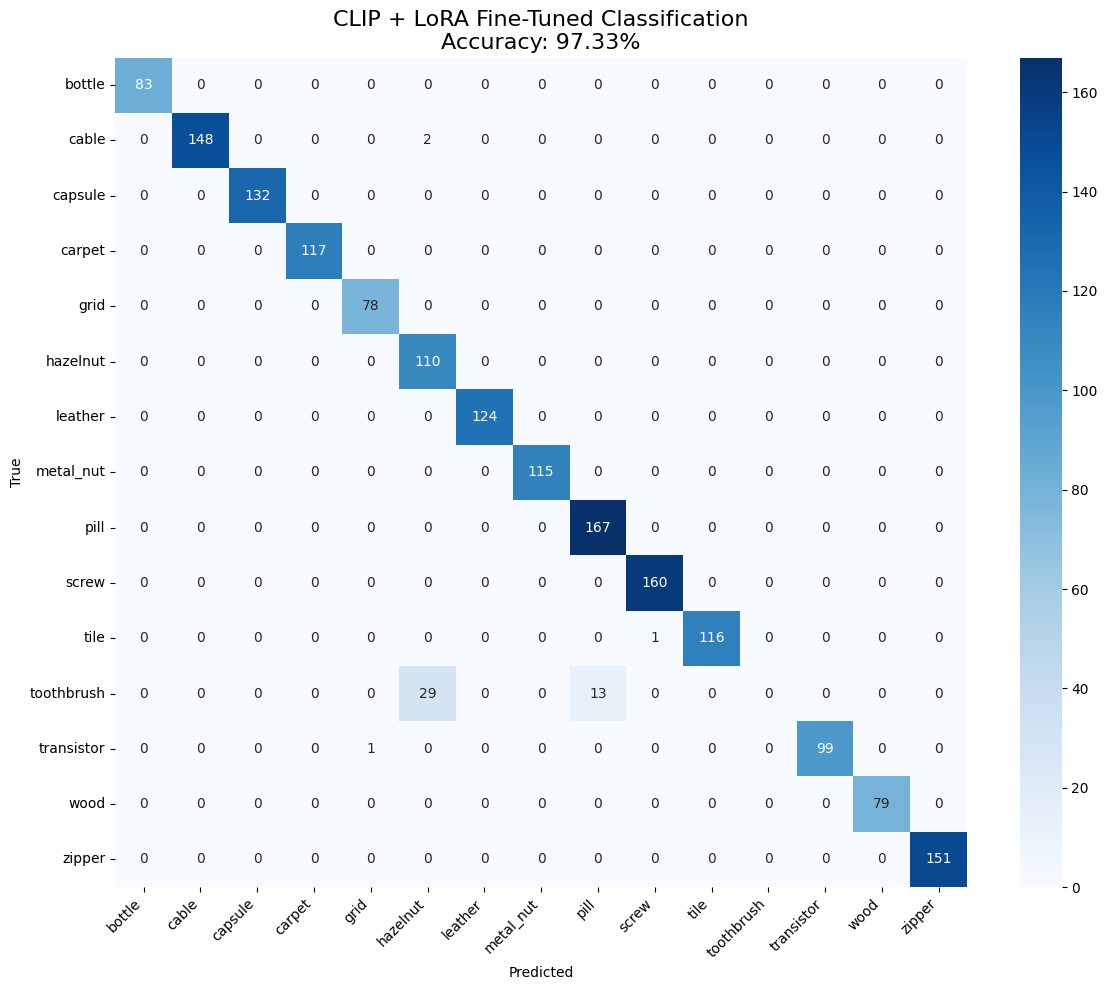


Detailed Classification Report:
              precision    recall  f1-score   support

      bottle     1.0000    1.0000    1.0000        83
       cable     1.0000    0.9867    0.9933       150
     capsule     1.0000    1.0000    1.0000       132
      carpet     1.0000    1.0000    1.0000       117
        grid     0.9873    1.0000    0.9936        78
    hazelnut     0.7801    1.0000    0.8765       110
     leather     1.0000    1.0000    1.0000       124
   metal_nut     1.0000    1.0000    1.0000       115
        pill     0.9278    1.0000    0.9625       167
       screw     0.9938    1.0000    0.9969       160
        tile     1.0000    0.9915    0.9957       117
  toothbrush     0.0000    0.0000    0.0000        42
  transistor     1.0000    0.9900    0.9950       100
        wood     1.0000    1.0000    1.0000        79
      zipper     1.0000    1.0000    1.0000       151

    accuracy                         0.9733      1725
   macro avg     0.9126    0.9312    0.9209    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.visual.eval()
classifier.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(device)

        # Extract visual features
        feats = model.visual(imgs)
        feats = feats / feats.norm(dim=-1, keepdim=True)

        # Classifier prediction
        logits = classifier(feats)
        preds = logits.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Convert to arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\n🎯 Fine-Tuned Accuracy: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title(f"CLIP + LoRA Fine-Tuned Classification\nAccuracy: {acc*100:.2f}%", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes, digits=4))


In [ ]:
import pandas as pd
from pathlib import Path

# Change this if your MVTec folder has a different name or location
data_root = Path("/content/drive/MyDrive/dataset/mvtec_anomaly_detection")  # Common alternatives: "./MVTec", "mvtec_anomaly_detection"

if not data_root.exists():
    raise FileNotFoundError(f"MVTec folder not found at {data_root}! Please check the path.")

# Folders to exclude (junk folders you mentioned)
exclude_folders = {
    '.git', 'autoencoder', 'mvtec-anomaly-detection-full',
    'processing', 'results', 'saved_models'
}

# Collect samples: only class label, from all test images (good + all defects)
samples = []

print("Generating CSV with only class labels from MVTec test set...")

for category in data_root.iterdir():
    if not category.is_dir():
        continue
    cat_name = category.name

    # Skip unwanted folders
    if cat_name in exclude_folders:
        print(f"Skipping excluded folder: {cat_name}")
        continue

    test_dir = category / "test"
    if not test_dir.exists():
        print(f"Skipping {cat_name} (no test folder)")
        continue

    # Go through all subfolders in test (good + all defect types)
    for subfolder in test_dir.iterdir():
        if subfolder.is_dir():
            for img_path in subfolder.glob("*.png"):
                # Use relative path for portability
                rel_path = img_path.relative_to(data_root.parent if data_root.parent != Path('.') else data_root)

                samples.append({
                    "filename": str(rel_path),
                    "class": cat_name
                })

# Create DataFrame
df = pd.DataFrame(samples)

# Save CSV
csv_filename = "mvtec_classes_only.csv"
df.to_csv(csv_filename, index=False)

print(f"\nDone! Generated {len(df)} rows (all test images).")
print(f"CSV saved as: {csv_filename}")
print(f"Classes included: {sorted(df['class'].unique())}")

print("\nFirst 10 rows preview:")
print(df.head(10))

print("\nClass distribution:")
print(df['class'].value_counts().sort_index())

Generating CSV with only class labels from MVTec test set...

Done! Generated 1725 rows (all test images).
CSV saved as: mvtec_classes_only.csv
Classes included: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']

First 10 rows preview:
                                            filename  class
0  mvtec_anomaly_detection/cable/test/bent_wire/0...  cable
1  mvtec_anomaly_detection/cable/test/bent_wire/0...  cable
2  mvtec_anomaly_detection/cable/test/bent_wire/0...  cable
3  mvtec_anomaly_detection/cable/test/bent_wire/0...  cable
4  mvtec_anomaly_detection/cable/test/bent_wire/0...  cable
5  mvtec_anomaly_detection/cable/test/bent_wire/0...  cable
6  mvtec_anomaly_detection/cable/test/bent_wire/0...  cable
7  mvtec_anomaly_detection/cable/test/bent_wire/0...  cable
8  mvtec_anomaly_detection/cable/test/bent_wire/0...  cable
9  mvtec_anomaly_detection/cable/test/bent_wire/0...  cabl

In [ ]:
from google.colab import files
files.download('mvtec_classes_only.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>